In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import integrate

%matplotlib inline

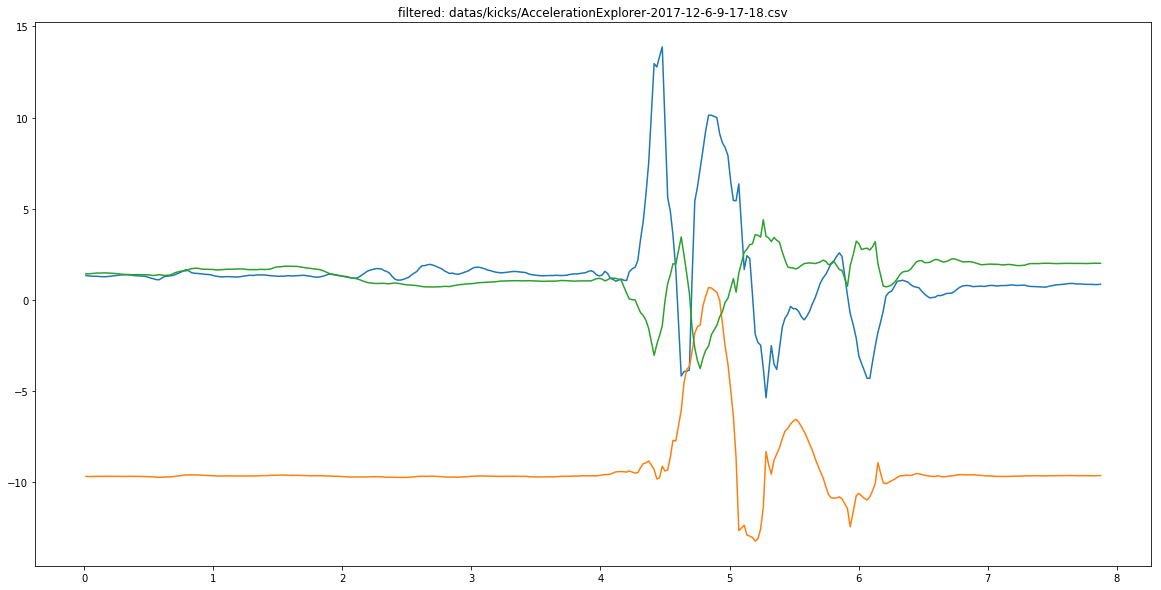

In [62]:
def read_csv(fname, sep):
    data = pd.read_csv(fname, sep)
    data = data.as_matrix()
    
    # remove row contains nan value
    data = data[~np.isnan(data).any(axis=1)]
    

    return data

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return ret[n - 1:] / n

def filter_data(fname, sep, cols=(1,), n=10, plot_raw=False, plot_filtered=True):
    kick_data = read_csv(fname, sep)
    
    # filter data using moving average filter
    filtered_len = kick_data.shape[0] - n + 1
    timestamp = kick_data[:filtered_len, 0]
    kick_data_filtered = []
    
    for col in cols:
        kick_data_filtered.append(moving_average(kick_data[:, col], n))

    if plot_raw:
        plt.figure(figsize=(20,10))
        plt.title('raw: '+ fname)
        plt.plot(kick_data[:, 0], kick_data[:, 1])
        plt.show()
        
    if plot_filtered:
        plt.figure(figsize=(20,10))
        plt.title('filtered: '+ fname)
        for col in cols:
            plt.plot(kick_data[:filtered_len, 0], kick_data_filtered[col-1])
    
    return (timestamp, np.array(kick_data_filtered))
filtered_data = filter_data('datas/kicks/AccelerationExplorer-2017-12-6-9-17-18.csv', ',', cols=(1,2,3))

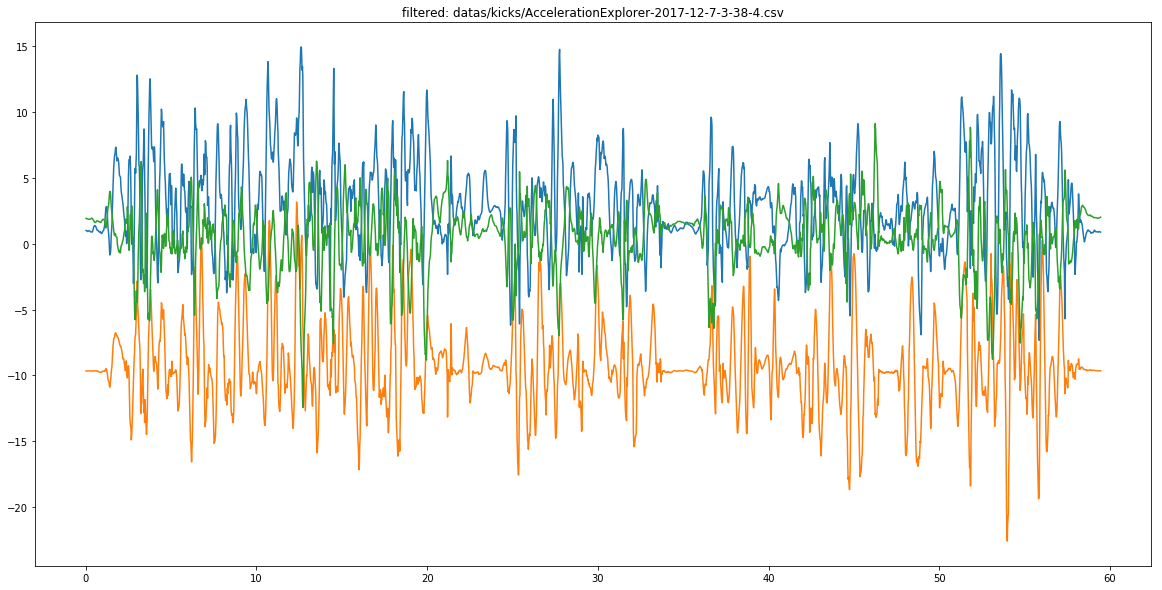

In [104]:
filtered_data = filter_data('datas/kicks/AccelerationExplorer-2017-12-7-3-38-4.csv', ',', cols=(1,2,3), plot_filtered=True)

alpha:  (2797,)
change:  (2797, 3)
change norm:  (2797, 1)


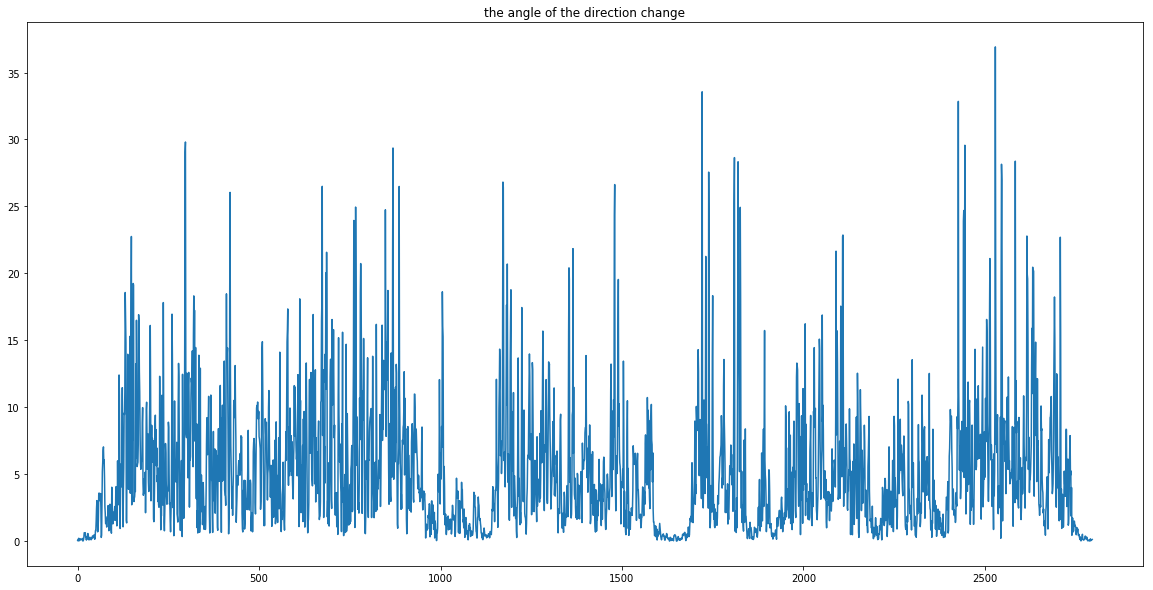

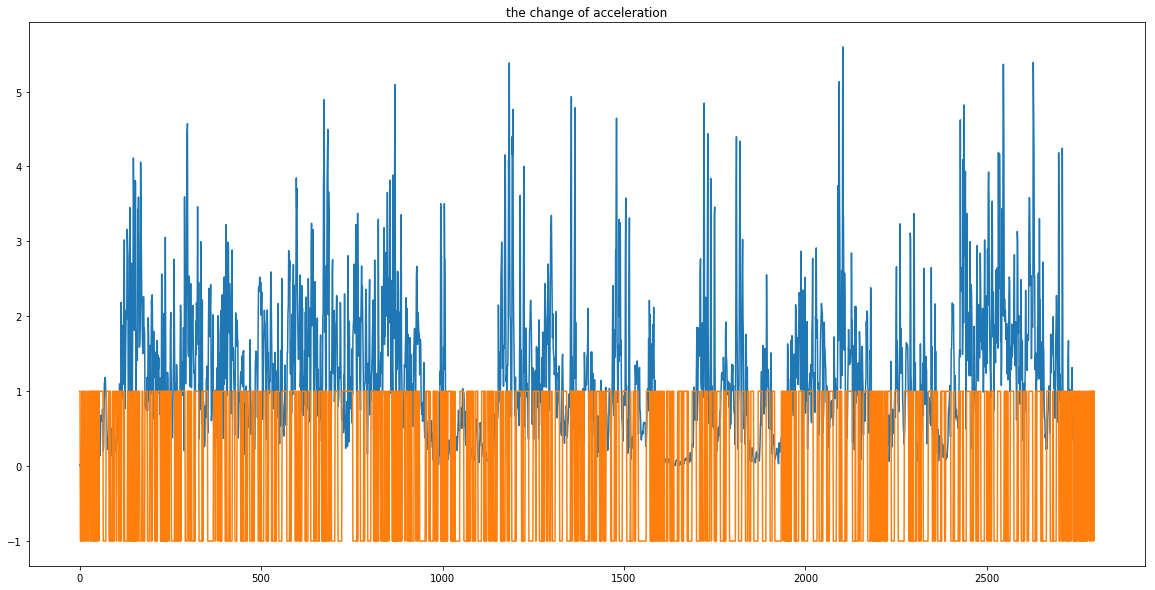

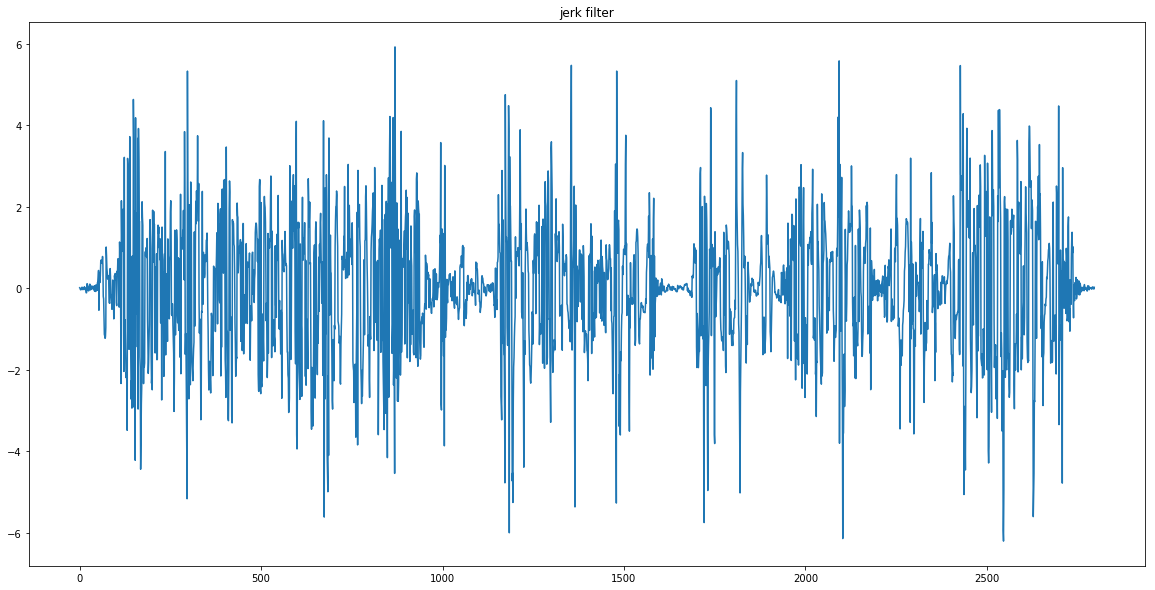

In [105]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_of_direction(accel_data, degree=False):
    """
    Return an array of the angle of the direction change.
    accel_data: acceleration input, a numpy array which has shape 3 x len
    """
    
    assert (accel_data.shape[0] == 3), "Invalid input"
    
    rad_to_deg = 57.29578
    ret = []
    len = accel_data.shape[1]
    accel_data = accel_data.T
    
    for i in range(1, len):
        ret.append(angle_between(accel_data[i-1], accel_data[i]))
    
    ret = np.array(ret)
    if degree:
        ret = ret * rad_to_deg
    
    return ret

def magnitude_of_direction(accel_data):
    """
    Return an array of the change of acceleration
    accel_data: acceleration input, has shape 3 x len
    """
    
    assert (accel_data.shape[0] == 3), "Invalid input."
    
    change = []
    sign = []
    len = accel_data.shape[1]
    accel_data = accel_data.T
    
    for i in range(1, len):
        if np.linalg.norm(accel_data[i]) > np.linalg.norm(accel_data[i-1]):
            sign.append(1)
        else:
            sign.append(-1)
        change.append(accel_data[i] - accel_data[i-1])
        
    change = np.array(change)
    sign = np.array(sign)
    mag = np.linalg.norm(change, axis=1, keepdims=True)
        
    return change, sign, mag

def jerk_filter(alpha, magnitude, sign):
    """
    alpha: angle of the direction change, in degree
    magnitude: the change of acceleration
    sign: returned by magnitude_of_direction function
    """
    
    assert (alpha.shape[0] == magnitude.shape[0] == sign.shape[0]), "alpha and magnitude must have same length."
    
    len = alpha.shape[0]
    jerk = []
    
    for i in range(len):
        val = (1 + alpha[i] / 180.0) * magnitude[i] * sign[i] 
        jerk.append(val)
        
    return jerk
    

alpha = angle_of_direction(filtered_data[1], degree=True)
c, s, m = magnitude_of_direction(filtered_data[1])
j = jerk_filter(alpha, m, s)

print('alpha: ', alpha.shape)
print('change: ', c.shape)
print('change norm: ', m.shape)

plt.figure(figsize=(20,10))
plt.title('the angle of the direction change')
plt.plot(alpha)
plt.show()

plt.figure(figsize=(20,10))
plt.title('the change of acceleration')
plt.plot(m)
plt.plot(s)
plt.show()

plt.figure(figsize=(20,10))
plt.title('jerk filter')
plt.plot(j)
plt.show()